In [1]:
%matplotlib inline

import numpy as np 
import os 
import sys 

import xarray as xr
import numpy as np
import matplotlib.pylab as plt
import matplotlib.cm as cm
#import cmocean.cm as cmo
from scipy.interpolate import CloughTocher2DInterpolator, LinearNDInterpolator, NearestNDInterpolator
#import gribscan
#import intake
from crick import TDigest as TDigestCrick
#import requests
#import aiohttp
#from httpfs import HTTPFileSystem


path = "/home/b/b382291/git/one_pass"
sys.path.append(path)
os.chdir(path)

from one_pass.opa import *
from one_pass.opa import Opa

# path = "/home/b/b382291/git/AQUA"
# sys.path.append(path)
# os.chdir(path)
# from aqua import Reader 

! hostname

l40347.lvt.dkrz.de


In [3]:
def attach_coords(ds):
    model_lon = ds.lon.values
    model_lat = ds.lat.values
    return ds.assign_coords(
        lat = (("value",), model_lat, {"units": "degree_north"}),
        lon = (("value",), model_lon, {"units": "degree_east"}),
    )

In [4]:
cat = intake.open_catalog("https://data.nextgems-h2020.eu/catalog.yaml")
ds = cat.IFS['IFS_4.4-FESOM_5-cycle3']['2D_1h_native'].to_dask() # load medium-resolution here, monthly means
ds_u100 = ds['100u']
ds_v100 = ds['100v']
ds = np.sqrt(ds_u100**2 + ds_v100**2)

In [5]:
# take 1 time step
ds_ll = ds.pipe(attach_coords).isel(time=0)
ds_ll

<xarray.DataArray (value: 26306560)>
dask.array<getitem, shape=(26306560,), dtype=float64, chunksize=(26306560,), chunktype=numpy.ndarray>
Coordinates:
    lat      (value) float64 89.97 89.97 89.97 89.97 ... -89.97 -89.97 -89.97
    lon      (value) float64 0.0 18.0 36.0 54.0 72.0 ... 288.0 306.0 324.0 342.0
    time     datetime64[ns] 2020-01-20
Dimensions without coordinates: value
Attributes: (12/15)
    paramId:                    228246
    dataType:                   fc
    numberOfPoints:             26306560
    typeOfLevel:                surface
    stepUnits:                  1
    stepType:                   instant
    ...                         ...
    name:                       100 metre U wind component
    cfVarName:                  u100
    missingValue:               9999
    totalNumber:                0
    NV:                         0
    gridDefinitionDescription:  Gaussian Latitude/Longitude Grid

# convering to lat lon grid 

In [6]:
ds

<xarray.DataArray (time: 43394, value: 26306560)>
dask.array<sqrt, shape=(43394, 26306560), dtype=float64, chunksize=(1, 26306560), chunktype=numpy.ndarray>
Coordinates:
    lat      (value) float64 dask.array<chunksize=(26306560,), meta=np.ndarray>
    lon      (value) float64 dask.array<chunksize=(26306560,), meta=np.ndarray>
  * time     (time) datetime64[ns] 2020-01-20 2020-01-20T01:00:00 ... 2025-01-01
Dimensions without coordinates: value
Attributes: (12/15)
    paramId:                    228246
    dataType:                   fc
    numberOfPoints:             26306560
    typeOfLevel:                surface
    stepUnits:                  1
    stepType:                   instant
    ...                         ...
    name:                       100 metre U wind component
    cfVarName:                  u100
    missingValue:               9999
    totalNumber:                0
    NV:                         0
    gridDefinitionDescription:  Gaussian Latitude/Longitude Grid

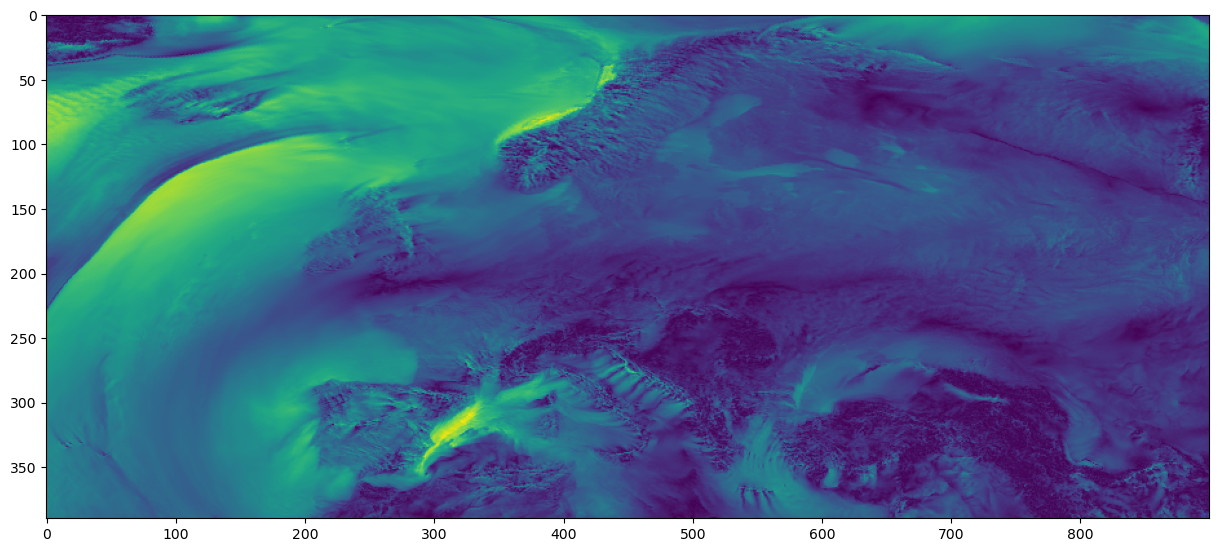

In [7]:
model_lon = ds.lon.values
model_lat = ds.lat.values
nonan = ~((np.isnan(model_lon)) | (np.isnan(model_lat)))
lat_nonan = model_lat[nonan]
lon_nonan = model_lon[nonan]
lon_nonan = np.where(lon_nonan>180, lon_nonan-360, lon_nonan)
points_ifs = np.vstack((lon_nonan, lat_nonan)).T

lon = np.linspace(-30, 60, 90*10)
lat = np.linspace(33, 72, (72-33)*10)
lon2, lat2 = np.meshgrid(lon, lat)

data_sample = ds[1,:]

nn_interpolation = NearestNDInterpolator(points_ifs, data_sample.values[nonan])
interpolated_nn = nn_interpolation((lon2, lat2))

plt.figure(figsize=(15,15))
plt.imshow(np.flipud(interpolated_nn))

This bit takes a while to compute 

In [8]:

## creating data 

def closest_value(input_list, input_value):
  arr = np.asarray(input_list)
  i = (np.abs(arr - input_value)).argmin()
  return arr[i]

model_lon = ds.lon.values
model_lat = ds.lat.values

target_lat = 58.235395
target_lon = -2.773114

target_lon_new = closest_value(model_lon, target_lon)
target_lat_new = closest_value(model_lat, target_lat)

nonan = ~((np.isnan(model_lon)) | (np.isnan(model_lat)))
lat_nonan = model_lat[nonan]
lon_nonan = model_lon[nonan]
lon_nonan = np.where(lon_nonan>180, lon_nonan-360, lon_nonan)
points_ifs = np.vstack((lon_nonan, lat_nonan)).T

lon = np.linspace(-30, 60, 90*10)
lat = np.linspace(33, 72, (72-33)*10)
lon2, lat2 = np.meshgrid(lon, lat)

# doing the time_series over the week 
time_series = np.zeros(169)

for i in range(169):
    data_sample = ds[i,:]
    nn_interpolation = NearestNDInterpolator(points_ifs, data_sample.values[nonan])
    interpolated_nn = nn_interpolation((target_lon, target_lat))
    time_series[i] = interpolated_nn
# Find the index of the target (lat, lon) in the unstructured grid
#target_index = np.where((model_lat == target_lat_new) & (model_lon == target_lon_new) & nonan)[0][0]

# Extract the value at the target (lat, lon) location
#target_value = data_sample.values[target_index]

saving this data so you don't have to re-make

In [9]:
file_path = '/home/b/b382291/git/data/time_series_gif_new.nc'
xr_timeseries = xr.DataArray(time_series)
xr_timeseries.to_netcdf(path = file_path, mode = 'w')

Loading the data

In [2]:
file_path = '/home/b/b382291/git/data/time_series_gif_new.nc'
time_series = xr.open_dataarray(file_path)
time_series = time_series.values 

In [3]:
def power_curve(iec_class,rated_power,cut_in_speed,rated_speed,cut_out_speed):
    """
    Compute the power curve of a wind turbine.

    Input
    -------
    iec_class: str
        IEC wind turbine class. Options are 'I','I/II', 'II', 'II/III', 'III', 'S'. 
    rated_power: int
        Rated power of the wind turbine in MW.
    cut_in_speed: float
        Cut-in speed of the wind turbine in m s^(-1).
    rated_speed: float
        Rated speed of the wind turbine in m s^(-1).
    cut_out_speed: float
        Cut-out speed of the wind turbine in m s^(-1).   

    Output
    -------
    pc: xarray.DataArray ; (time,lat,lon)
        Power curve.
    
    References
    -------
    [1]: https://www.thewindpower.net/turbine_es_5_enercon_e70-2300.php
    [2]: https://www.thewindpower.net/turbine_es_44_gamesa_g80-2000.php
    [3]: https://www.thewindpower.net/turbine_es_46_gamesa_g87-2000.php
    [4]: https://www.thewindpower.net/turbine_es_779_vestas_v100-2000.php
    [5]: https://www.thewindpower.net/turbine_es_590_vestas_v110-2000.php
    [6]: https://www.thewindpower.net/turbine_es_1476_vestas_v164-9500.php
    """
    from scipy.optimize import curve_fit

    # if not isinstance (rated_power, (float,int)):
    #     raise TypeError('The input variable "rated_power" must be a float or an integer.')
    # assert get_type(cut_in_speed) == 'float', 'The input variable "cut_in_speed" is not a float.'
    # assert get_type(rated_speed) == 'float', 'The input variable "rated_speed" is not a float.'
    # assert get_type(cut_out_speed) == 'float', 'The input variable "cut_out_speed" is not a float.'
   
    #Check if the IEC class is valid.
    if iec_class not in ['I','I_II','II','II_III','III','S']:
        raise ValueError('The IEC class is not valid. Options are "I","I/II", "II", "II/III", "III", "S".')

    iec_to_t = {'I': 0,'I_II': 1,'II': 2,'II_III': 3,'III': 4, 'S':5}
    t = iec_to_t.get(iec_class, -1)

    turbines = ['Enercon_E70_2.3MW', 'Gamesa_G80_2.0MW', 'Gamesa_G87_2.0MW', 'Vestas_V100_2.0MW', 'Vestas_V110_2.0MW',
               'Vestas_V164_9.5MW']

    #Read the csv file with the manufacturer power curve.
    power_curve_data = pd.read_csv('/home/b/b382291/git/data/power_curves/' + turbines[t] + '.csv',skiprows=1, sep = ',')

    #Define a parametrized Weibull Cumulative Distribution Function to fit the power curve.

    def weibull_distribution(x, alfa, k):
        f = rated_power - rated_power*np.exp(-(x*alfa)**k)
        return f
    
    x_data = power_curve_data.wind_speed[:]
    y_data = power_curve_data['\tpower']

    popt, pcov = curve_fit(weibull_distribution, x_data, y_data, p0=(0.1, 1))

    # Extract the optimized parameters
    alfa_opt, k_opt = popt

    x = np.linspace(0, 30, 10000)
    pc = np.zeros((len(x)))

    for v in range(len(x)):
        if x[v] < cut_in_speed:
            pc[v] = 0
        elif x[v] >= cut_in_speed and x[v] <= rated_speed:
            pc[v] = weibull_distribution(x[v], alfa_opt, k_opt)
        elif x[v] > rated_speed and x[v] <= cut_out_speed:
            pc[v] = rated_power
        elif x[v] > cut_out_speed:
            pc[v] = 0

    #Store the power curve and the wind values in an xarray.DataArray.
    attrs = {'long_name':'Power curve','units':'kW'}
    pc = xr.DataArray(pc,coords=[x],dims=['wind_speed'],attrs=attrs)

    return pc

In [5]:
turbines = ['Enercon_E70_2.3MW' , 'Gamesa_G80_2.0MW', 'Gamesa_G87_2.0MW', 'Vestas_V100_2.0MW', 'Vestas_V110_2.0MW',
            'Vestas_V164_9.5MW']
power_curve_data = pd.read_csv('/home/b/b382291/git/data/power_curves/' + turbines[0] + '.csv',skiprows=1, sep = ',')


In [6]:

wind_speed = time_series
iec_class = 'S'
"""
Compute the capacity factor of a wind turbine.

Input
-------
wind_speed: xarray.DataArray ; (time,lat,lon)
    Wind speed magnitude.
iec_class: str
    IEC wind turbine class. Options are 'I','I/II', 'II', 'II/III', 'III', 'S'.

Output
-------
cf: xarray.DataArray ; (time,lat,lon)
    Capacity factor.

References
-------
[1]: 

"""
import multiprocessing

#Check if the IEC class is valid.
if iec_class not in ['I','I_II','II','II_III','III', 'S']:
    raise ValueError("Input argument 'iec_class' must be 'I','I/II','II','II/III', 'III' or 'S'.")

class_I = {'turbine_model': 'Enercon E70','rotor_diameter': 70, 'rated_power': 2.3, 'cut_in_speed': 2.0, 'rated_speed': 15.5, 'cut_out_speed': 25.0}
class_I_II = {'turbine_model': 'Gamesa G80','rotor_diameter': 80, 'rated_power': 2.0, 'cut_in_speed': 3.5, 'rated_speed': 15.0, 'cut_out_speed': 25.0}
class_II = {'turbine_model': 'Gamesa G87','rotor_diameter': 87, 'rated_power': 2.0, 'cut_in_speed': 3.0, 'rated_speed': 14.0, 'cut_out_speed': 25.0}
class_II_III = {'turbine_model': 'Vestas V100','rotor_diameter': 100, 'rated_power': 2.0, 'cut_in_speed': 3.5, 'rated_speed': 12.0, 'cut_out_speed': 20.0}
class_III = {'turbine_model': 'Vestas V110','rotor_diameter': 110, 'rated_power': 2.0, 'cut_in_speed': 4.0, 'rated_speed': 12.0, 'cut_out_speed': 20.0}
class_S = {'turbine_model': 'Vestas V164','rotor_diameter': 164, 'rated_power': 9.5, 'cut_in_speed': 3.5, 'rated_speed': 14.0, 'cut_out_speed': 25.0}

turbine_class = [class_I, class_I_II, class_II, class_II_III, class_III, class_S]

iec_to_t = {'I': 0,'I_II': 1,'II': 2,'II_III': 3,'III': 4, 'S': 5}
t = iec_to_t.get(iec_class, -1)

#Compute the power curve of the wind turbine.

rated_power = turbine_class[t]['rated_power']*10**3 #kW
cut_in_speed = turbine_class[t]['cut_in_speed']
rated_speed = turbine_class[t]['rated_speed']
cut_out_speed = turbine_class[t]['cut_out_speed']

pc = power_curve(iec_class,rated_power,cut_in_speed,rated_speed,cut_out_speed)

# Define a function to calculate pu for a given (i, j) position
global calculate_power_output

def calculate_power_output(i,power_curve,wind_speed):
    diff = np.abs(np.subtract.outer(power_curve.wind_speed.values, wind_speed[i]))
    closest_indices = np.argmin(diff, axis=0)
    return power_curve[closest_indices] 

# Create a list of all (i, j) positions
jobargs = [(i, pc, wind_speed) for i in range(wind_speed.shape[0])] # for j in range(wind_speed.shape[1])]

# Create a pool with the number of desired processes
num_processes = multiprocessing.cpu_count()  # Adjust this value based on your system capabilities

with multiprocessing.Pool(num_processes) as pool:
    res = list(pool.starmap(calculate_power_output, jobargs))

pool.close()
pool.join()

# Convert the results back to the pu array
power_output = np.array(res).reshape(wind_speed.shape[0]) #, wind_speed.shape[1])

#Compute the capacity factor.

cf = power_output/rated_power

attrs = {'long_name':'Capacity factor','units':'-'}
cf = xr.DataArray(cf,attrs=attrs)



In [7]:
cf.values

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 0.97943346, 0.98198638,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 0.97921433, 0.91439479, 0.31969081, 0.25932967,
       0.17246475, 0.10898336, 0.08107703, 0.07176771, 0.02787304,
       0.01489141, 0.03381181, 0.02410158, 0.02787304, 0.05053093,
       0.05027979, 0.0296169 , 0.01287004, 0.0484251 , 0.15294734,
       0.24102652, 0.16722894, 0.09470682, 0.06473873, 0.02233098,
       0.        , 0.        , 0.        , 0.        , 0.01551045,
       0.01598725, 0.03832762, 0.07373043, 0.15105079, 0.32929075,
       0.48066446, 0.44347664, 0.31927634, 0.20243307, 0.30290379,
       0.57175706, 0.54934758, 0.56937756, 0.69475207, 0.72313497,
       0.71036569, 0.8531362 , 0.91180341, 0.89364742, 0.94481

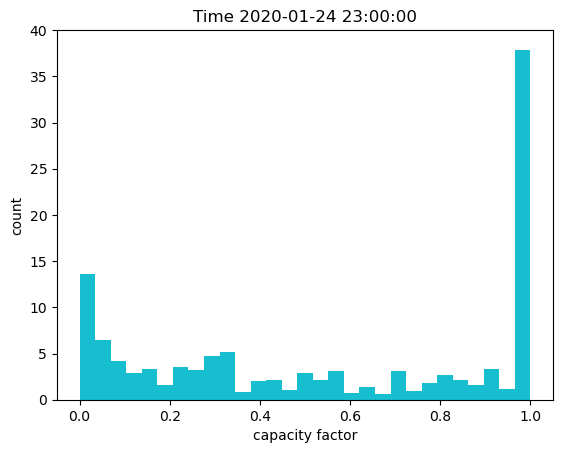

In [9]:
#wpd = (0.5*1.225*time_series**3)/1000

# looking at using capacity factor calculated above 

time_series = cf.values

bins_space = np.linspace(0, 1, 30)
#u_1d = np.resize(data_sample, np.size(data_sample))
n = 120 # np.size(time_series)
dictlist = [dict() for x in range(n)]    
digest = TDigestCrick() 

tvec = np.arange(np.datetime64('2020-01-20'), np.datetime64('2020-01-25'),dtype='datetime64[h]')

# looking over 5 days
for i in range(120):
    # call the same function with different data in parallel
    digest.update(time_series[i])
    
    if (np.mod(i, 1) == 0):

        hist_data = digest.histogram(bins_space, [0,1])
        
        #hist_data[1] = 0.5*1.225*hist_data[1]**3
        bins =  hist_data[1]
        weights = hist_data[0]
        #hist_data[1] = bins
        
        #plot_loc = np.where(weights != 0)

        bins_new = bins #[plot_loc]
        weights_new = weights #[plot_loc]

        plt.hist(bins_new[:-1], bins = bins_new, weights = weights_new)
        plt.xlabel('capacity factor')
        plt.ylabel('count')
        plt.title(f'Time {pd.Timestamp(tvec[i])}')  # Set the title for the current frame
        plt.ylim([0, 40])
        dictlist[i] = hist_data

In [50]:
plot_loc

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]),)

In [10]:
digest.centroids()

array([(0.        , 1.), (0.        , 1.), (0.        , 1.),
       (0.        , 1.), (0.01287004, 1.), (0.01489141, 1.),
       (0.01551045, 1.), (0.01598725, 1.), (0.02233098, 1.),
       (0.02410158, 1.), (0.02787304, 1.), (0.02787304, 1.),
       (0.0296169 , 1.), (0.03381181, 1.), (0.03832762, 1.),
       (0.0484251 , 1.), (0.05027979, 1.), (0.05053093, 1.),
       (0.05948249, 1.), (0.06473873, 1.), (0.07176771, 1.),
       (0.07373043, 1.), (0.08107703, 1.), (0.09470682, 1.),
       (0.10533718, 1.), (0.10768675, 1.), (0.10898336, 1.),
       (0.15105079, 1.), (0.15294734, 1.), (0.16722894, 1.),
       (0.17246475, 1.), (0.20243307, 1.), (0.21063367, 1.),
       (0.21868816, 1.), (0.23040096, 1.), (0.24102652, 1.),
       (0.24535212, 1.), (0.25932967, 1.), (0.26989639, 1.),
       (0.29288075, 1.), (0.29807217, 1.), (0.29887482, 1.),
       (0.30290379, 1.), (0.31063016, 1.), (0.31927634, 1.),
       (0.31969081, 1.), (0.32929075, 1.), (0.33986823, 1.),
       (0.34072068, 1.),

In [11]:
dictlist[0]

(array([0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0.5]),
 array([0.        , 0.03448276, 0.06896552, 0.10344828, 0.13793103,
        0.17241379, 0.20689655, 0.24137931, 0.27586207, 0.31034483,
        0.34482759, 0.37931034, 0.4137931 , 0.44827586, 0.48275862,
        0.51724138, 0.55172414, 0.5862069 , 0.62068966, 0.65517241,
        0.68965517, 0.72413793, 0.75862069, 0.79310345, 0.82758621,
        0.86206897, 0.89655172, 0.93103448, 0.96551724, 1.        ]))

In [29]:
bins = hist_data[1]

MovieWriter Pillow unavailable; using Pillow instead.


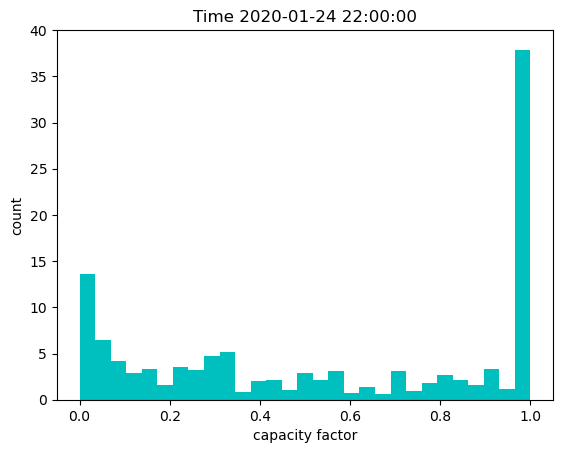

In [12]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

frame_data = dictlist  # Your list of frame data
tvec = np.arange(np.datetime64('2020-01-20'), np.datetime64('2020-01-25'),dtype='datetime64[h]')

fig, ax = plt.subplots()

def update(frame):
    
    ax.clear()  # Clear the previous frame
    hist_data = frame_data[frame+1]  # Get the data for the current frame

    bins = hist_data[1]
    weights = hist_data[0]
    
    #bins = 0.5*1.225*bins**3

    bins_new = bins #[plot_loc]
    weights_new = weights #[plot_loc]

    _, _, patches = ax.hist(bins_new[:-1], bins = bins_new, weights = weights_new, color = 'c')
    ax.set_xlabel('capacity factor')
    #ax.set_xlabel('100 m wind speed (m/s)')
    ax.set_ylabel('count')
    ax.set_title(f'Time {pd.Timestamp(tvec[frame])}')  # Set the title for the current frame
    ax.set_ylim([0, 40])
    
    return patches  # Return the modified patches

animation = FuncAnimation(fig, update, frames=len(frame_data)-1, interval=100, blit=True)

#file_path = '/home/b/b382291/git/one_pass/histogram_wind_speed.gif'
file_path = '/home/b/b382291/git/one_pass/histogram_cf.gif'
animation.save(file_path, writer='Pillow', fps=6.25)

Making the plots to show storage space 

# aleks code 

In [ ]:
import matplotlib.dates as mdates
from matplotlib.animation import FuncAnimation
tvec = np.arange(np.datetime64('21-06-01'), np.datetime64('21-06-10'),dtype='datetime64[h]')
x = []
for i in range(len(tvec)):
    x.append(str(tvec[i]).replace('-',''))

fig = plt.figure(constrained_layout=True,figsize=(20,5))
fig.subplots_adjust(bottom=0.14, top=0.90, left=0.05, right=0.95)
nrow = 1
ncol = 1
outer = gs.GridSpec(nrow,ncol,wspace=0.01,hspace=0.02)

ax = plt.subplot(outer[0])
line, = ax.plot([], [], label='wpd', c='darkred', linewidth=3)

#ax.plot(tvec,wpd,label='wpd',c='darkred',linewidth=3)

ax.set_ylabel('WPD (W $m^{-2}$)',fontsize=18)
#ax.set_xlabel('Time (hours)',fontsize=18)
ax.set_title('WPD at Moray East (58.2354 N, -2.7731 E)',fontsize=20)
#ax.legend(fontsize=16)
ax.xaxis.set_major_locator(mdates.HourLocator(interval=24))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.tick_params(axis='both',labelsize=18)
ax.tick_params(axis='x',rotation=30,labelsize=16)
#ax.set_xticklabels(rotation=45,labels=tvec,fontsize=16,ha='right')
ax.set_xlim([np.datetime64('21-06-01'), np.datetime64('21-06-10')])
ax.set_ylim([0, 1200])
ax.grid(ls='--',color='gray',alpha=0.5)

def update(frame):
    line.set_data(tvec[:frame], wpd[:frame])
    return line,

ani = FuncAnimation(fig, update, frames=len(tvec), interval=100, blit=True)
# save animation to file
ani.save('./plots/timeseries/wpd_ICON_North_Sea.gif', fps=6.25)

In [82]:
time_series

array([5.06960625, 4.71633092, 4.25546399, 3.59332822, 3.47470339,
       4.12210902, 4.54740417, 4.54120722, 4.78902712, 5.08324737,
       5.23940506, 5.42580052, 5.12795805, 5.25596913, 5.79385098,
       7.08389822, 6.32312073, 6.03817114, 6.58392093, 6.89755032,
       6.74145265, 6.85751543, 7.549286  , 6.021726  , 6.05307579,
       5.81477054, 5.50643389, 5.46357267, 5.48186277, 5.91645808,
       6.16399571, 6.75804352, 6.71425059, 6.93988877, 6.66996344,
       6.30280232, 5.42832519, 5.30875522, 5.40806376, 6.00725176,
       5.4201525 , 5.21787279, 5.85904125, 5.89730239, 5.96133502,
       5.86589534, 5.9762145 , 6.05233045, 6.38204702, 6.92088961,
       7.07706622, 7.17020549, 7.09778527, 7.58818598, 7.73189231,
       7.58939137, 7.26021703, 7.38791678, 7.25113824, 7.31614435,
       7.18868532, 7.34242348, 7.29528056, 7.24098714, 7.25302386,
       6.78773911, 6.62019782, 6.77463207, 6.54625524, 6.22922359,
       6.04255177, 6.18117977, 6.65140476, 6.59396963, 6.21419